#### **Exercise 1**

Remove the outliers from the `sample_data_with_outliers.csv`!  Plot boxplots of the two features before and after outlier removal.  Try using different methods.  What works the best?

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

# More complex example data
np.random.seed(0)

url = "data/sample_data_with_outliers.csv"
df = pd.read_csv(url, header=0)
df.head()

df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Age       200 non-null    int64
 1   Income    200 non-null    int64
 2   Purchase  200 non-null    int64
dtypes: int64(3)
memory usage: 4.8 KB


/tmp/ipykernel_25282/2677632724.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '58.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_imputed['Age'].where(~df.index.isin(outliers_z_score.index), df['Age'].median(), inplace=True)


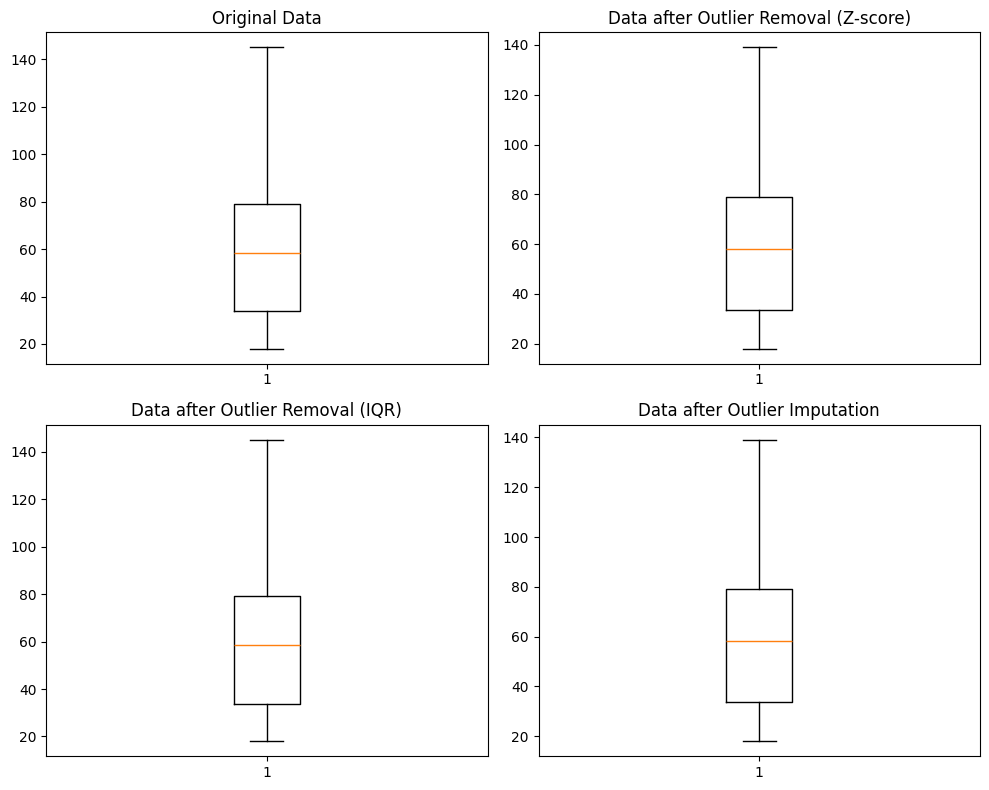

In [7]:
# Original DataFrame
original_df = df.copy()

# Detecting outliers using Z-score
df['Z_Score'] = zscore(df['Age'])
outliers_z_score = df[np.abs(df['Z_Score']) > 3]
# Detecting outliers using IQR method
Q1 = df['Age'].quantile(0.25)
Q3 = df['Age'].quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = df[(df['Age'] < (Q1 - 1.5 * IQR)) | (df['Age'] > (Q3 + 1.5 * IQR))]

# Handling outliers: Removal
df_no_outliers_z = df[np.abs(df['Z_Score']) <= 3]
df_no_outliers_iqr = df[(df['Age'] >= (Q1 - 1.5 * IQR)) & (df['Age'] <= (Q3 + 1.5 * IQR))]
# Handling outliers: Imputation (Replace with Median)
df_imputed = df.copy()
df_imputed['Age'].where(~df.index.isin(outliers_z_score.index), df['Age'].median(), inplace=True)
# Create Subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 0].boxplot(original_df['Age'])
axs[0, 0].set_title('Original Data')

axs[0, 1].boxplot(df_no_outliers_z['Age'])
axs[0, 1].set_title('Data after Outlier Removal (Z-score)')

axs[1, 0].boxplot(df_no_outliers_iqr['Age'])
axs[1, 0].set_title('Data after Outlier Removal (IQR)')
axs[1, 1].boxplot(df_imputed['Age'])
axs[1, 1].set_title('Data after Outlier Imputation')

plt.tight_layout()
plt.show()



<Axes: xlabel='Age', ylabel='Income'>

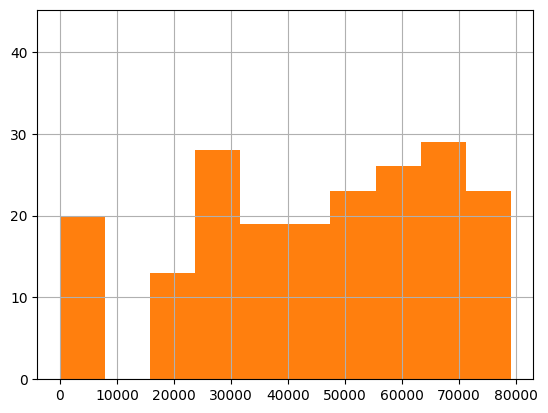

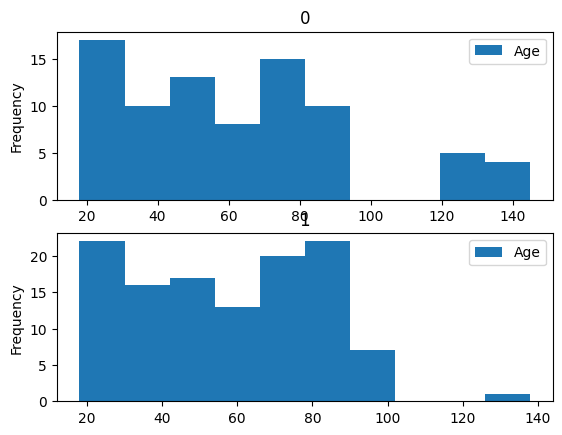

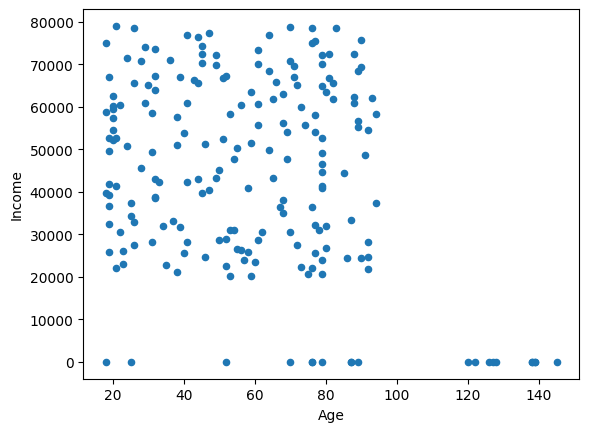

In [41]:
(df['Age']).hist()
df['Income'].hist()

df[["Age","Purchase"]].plot.hist(by="Purchase")

df[df['Age']>90].value_counts().sum()

pd.DataFrame(df[["Age","Income"]]).plot(kind="scatter",x="Age",y="Income")


DataFrame outliers:
      Age  Income  Purchase
1     88   62405         0
6     53   58360         0
7     88   60818         0
8     91   48643         0
11    20   62642         0
..   ...     ...       ...
187   79   52745         0
189   23   26102         0
192   83   78483         1
193  139      31         0
194   25      86         0

[89 rows x 3 columns]


<Axes: xlabel='Age', ylabel='Income'>

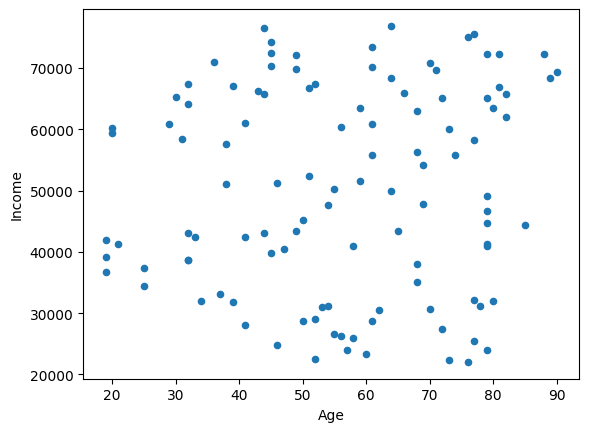

In [54]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import IsolationForest

class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, n_estimators=40, contamination='auto'):
        self.n_estimators = n_estimators
        self.contamination = contamination

    def fit(self, X, y=None):
        self.isolation_forest = IsolationForest(n_estimators=self.n_estimators, 
                                                contamination=self.contamination)
        self.isolation_forest.fit(X)
        return self

    def transform(self, X, y=None):
        # Predict outliers (-1 for outliers, 1 for inliers)
        outliers = self.isolation_forest.predict(X)
        
        # Filter out the outliers
        inliers_df = X[outliers == 1]
        
        # Extract outliers
        outliers_df = X[outliers == -1]

        return inliers_df, outliers_df

# Create an instance of OutlierRemover
outlier_remover = OutlierRemover(n_estimators=100, contamination='auto')

# Fit the OutlierRemover to your data
outlier_remover.fit(df)

# Transform the data to remove outliers
df_no_outliers, df_outliers = outlier_remover.transform(df)

# Print the original DataFrame, DataFrame without outliers, and DataFrame with outliers
#print("Original DataFrame:\n", df)
#print("\nDataFrame without outliers:\n", df_no_outliers)
print("\nDataFrame outliers:\n", df_outliers)
pd.DataFrame(df_no_outliers[["Age","Income"]]).plot(kind="scatter",x="Age",y="Income")

#### **Exercise 2**

In the following, I've created a sample dataset with an exponential feature and a normal feature. Try using the different scaling methods before running the classifier.  How do your results change:

1.  If you scale the exponential feature using a StandardScaler
2.  If you scale the exponential feature using a Log transform

Logistic Regression without Scaling - Test Accuracy: 0.72


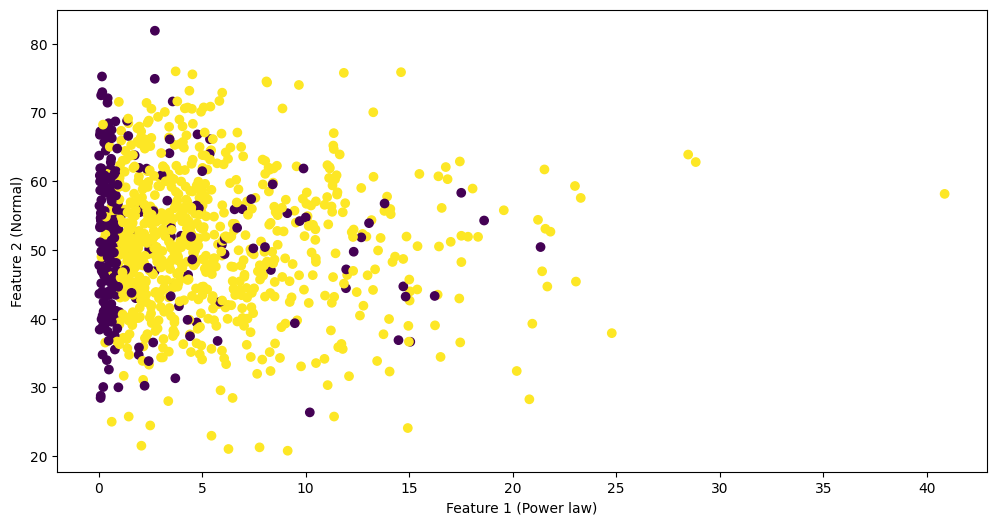

In [22]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Create synthetic dataset
n_samples = 1000

# Feature 1: Power law (exponential) distribution
X1 = np.random.exponential(scale=5, size=n_samples)

# Feature 2: Normal distribution
X2 = np.random.normal(loc=50, scale=10, size=n_samples)

# Create labels: simple linear relation to X1 and X2
y = np.array([1 if x1 + 0.001 * x2 > 1 else 0 for x1, x2 in zip(X1, X2)])
flip_indices = np.random.choice(n_samples, size=int(0.1 * n_samples), replace=False)
y[flip_indices] = 1 - y[flip_indices]



# Combine features into single data array
X = np.column_stack((X1, X2))

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression without scaling
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
print(f"Logistic Regression without Scaling - Test Accuracy: {lr.score(X_test, y_test):.2f}")

# Plot original features
plt.figure(figsize=(12, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.xlabel('Feature 1 (Power law)')
plt.ylabel('Feature 2 (Normal)')
plt.show()




#### **Exercise 3**

The **Titanic dataset** (link to the data from [last week](../2-week2//data/titanic.csv)) contains the passenger list for all 768 passengers on the Titanic, as well as who survived. In this exercise, try using different methods for dealing with the nulls in the "age" column, and running the same classifier for the different methods (you might try a DecisionTreeClassifier, or a LogisticRegression classifier, or a SGDClassifier).  Which one gives the best result?  Why do you think that is?  Please only use the following columns for modeling: pclass, sex, age, sibsp, parch.  Be sure to try the following methods:

1. Fill forward, using 'ffill' in Pandas
2. Use a "mean" with a SimpleImputer
3. Use a "most_frequent" with a simple imputer
4. Use a KNN imputer from sklearn

#### **Exercise 4**

Use the one-hot encoding method introduced in [](4-encoding.ipynb) for encoding multiple columns to one-hot encode the following data. 

In [ ]:
sample = pd.DataFrame({
    'color': ['red', 'blue', 'green', 'red', 'blue', 'green'],
    'target': ['apple', 'sky', 'grass', 'sky', 'moon', 'apple'],
    'yumminess': [10,2,3,1,6,9]
})

# Your code here

#### **Exercise 5**

In along with this notebook, there is a data file called `synthetic_patient_unbalanced.csv` which simulates a dataset of patients who have been examined for cardiovascular disease (CVD).  The data contains the following columns:

#### Columns:
1. **gender** (Categorical): Gender of the patient. (Male, Female)
2. **age** (Numeric): Age of the patient.
3. **bmi** (Numeric): Body Mass Index of the patient.
4. **systolic_bp** (Numeric): Systolic blood pressure level of the patient.
5. **diastolic_bp** (Numeric): Diastolic blood pressure level of the patient.
6. **cholesterol_level** (Numeric): Cholesterol level of the patient. 
7. **exercise_frequency** (Categorical): How often the patient exercises.
8. **smoker** (Categorical): Whether the patient is a smoker or not. (0=No, 1=Yes).
9. **family_history** (Categorical): Whether the patient has a family history of the disease. (0=No, 1=Yes).
10. **diet_quality** (Categorical): Quality of the patient's diet. 
11. **us_state** (Categorical): The US State where the patient resides.
12. **has_disease** (Binary): Whether the patient has the disease or not. (0=No, 1=Yes).

#### Task:

1. After pre-processing the data, perform an end-to-end analysis.  
2. Compare your results with and without re-balancing your classes.
3. Evaluate precision, recall, f1-score, and accuracy using 5-fold cross-validation.